In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats
warnings.filterwarnings('ignore')

In [130]:
data = pd.read_csv('TRACE_treasurydata_sample.csv')
data.head()

,Record Count Num,Reference Number,Trade Status,TRACE Symbol,FIGI,Benchmark Type,Maturity Date,Sub Product,When Issued Indicator,Remuneration,...,Contra Party Indicator,Locked In Indicator,ATS Indicator,Aggregate Indicator,Special Price Indicator,Dissemination Flag,Prior Trade Report Date,Prior Reference Number,First Trade Control Date,First Trade Control Number
0,1,45793,T,TSRYS5073461,BBG00Y2NNDT7,10Y,20301115,NOTE,N,NaN,...,D,NaN,NaN,N,NaN,N,NaN,NaN,20201127,45793
1,2,45791,Y,TSRYS5073461,BBG00Y2NNDT7,10Y,20301115,NOTE,N,NaN,...,D,NaN,NaN,N,NaN,N,20201119.0,311486.0,20201119,311486
2,3,6440,Y,TSRYS5073461,BBG00Y2NNDT7,10Y,20301115,NOTE,N,NaN,...,C,NaN,NaN,Y,NaN,Y,20201120.0,4365.0,20201120,4365
3,4,6446,T,TSRYS5073461,BBG00Y2NNDT7,10Y,20301115,NOTE,N,NaN,...,A,NaN,NaN,Y,NaN,Y,NaN,NaN,20201127,6446
4,5,84142,T,TSRYS5073463,BBG00Y2NNDH0,3Y,20231115,NOTE,N,NaN,...,C,NaN,NaN,Y,NaN,Y,NaN,NaN,20201127,84142


In [132]:
# Preprocess 'BenchmarkType' to remove 'Y' and convert to numeric
data['BenchmarkType'] = data['Benchmark Type'].str.rstrip('Y').astype(float)

# Select 'Yield', 'Quantity', and 'Price' as features (X) and Bond Level as the target (Y)
X = data[['Yield', 'Quantity', 'Price']]
y = data['BenchmarkType']

X['Yield'] = pd.to_numeric(X['Yield'], errors='coerce')
X['Quantity'] = pd.to_numeric(X['Quantity'], errors='coerce')
X['Price']= pd.to_numeric(X['Price'], errors= 'coerce')
y = pd.to_numeric(y, errors='coerce')


data_clean = pd.concat([X, y], axis=1).dropna()
X = data_clean[['Yield', 'Quantity', 'Price']]
y = data_clean['BenchmarkType']

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

#Standard Scaler used to scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [133]:
# Perform OLS Regression
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)
y_pred_ols = ols.predict(X_test_scaled)

mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)
print(f'OLS Regression - MSE: {mse_ols}, R2: {r2_ols}')


# Perform Ridge Regression
ridge = Ridge(alpha=1)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'Ridge Regression - MSE: {mse_ridge}, R2: {r2_ridge}')

OLS Regression - MSE: 0.229720130598405, R2: 0.9968149773241665
Ridge Regression - MSE: 0.36779187976819766, R2: 0.9949006407318433


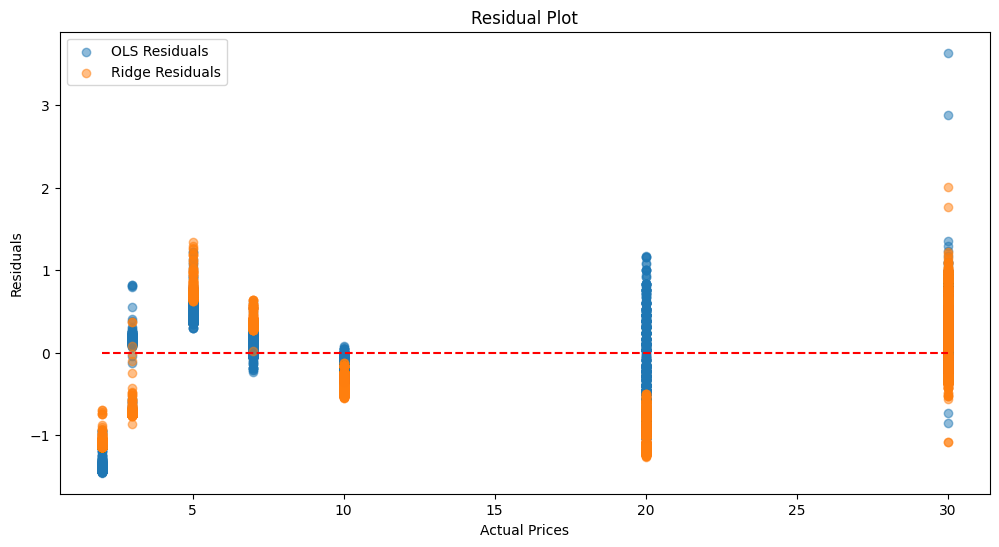

In [134]:
# Plot Residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test - y_pred_ols, label='OLS Residuals', alpha=0.5)
plt.scatter(y_test, y_test - y_pred_ridge, label='Ridge Residuals', alpha=0.5)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r', linestyles='dashed')
plt.legend()
plt.title('Residual Plot')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.show()

In [135]:
# Calculate t-statistics and p-values
n = X_train_scaled.shape[0]  # number of observations
k = X_train_scaled.shape[1]  # number of features
df = n - k - 1  # degrees of freedom

# Residual sum of squares
rss = np.sum((y_train - ols.predict(X_train_scaled))**2)

# Mean squared error
mse = rss / df

# Variance-Covariance Matrix
vcov = mse * np.linalg.pinv(np.dot(X_train_scaled.T, X_train_scaled))

# Standard errors of coefficients
se = np.sqrt(np.diag(vcov))

# Coefficients
coefficients = ols.coef_

# t-statistics
t_stats = coefficients / se

# p-values
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]

# Get feature names
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Display results
results = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Standard Error': se,
    't-statistic': t_stats,
    'p-value': p_values
})

# Determine significance at the 0.05 level
alpha = 0.05
results['Significant'] = results['p-value'] < alpha

print(results)

          Feature  Coefficient  Standard Error  t-statistic       p-value  \
0               1     0.000000        0.000000          NaN           NaN   
1           Yield  -319.073901        1.420295  -224.653187  0.000000e+00   
2        Quantity    -6.378805        1.003559    -6.356186  2.078757e-10   
3           Price   124.692442        1.561890    79.834330  0.000000e+00   
4         Yield^2     6.446868        0.010166   634.136715  0.000000e+00   
5  Yield Quantity     0.024306        0.003328     7.302919  2.839950e-13   
6     Yield Price   322.439409        1.434967   224.701672  0.000000e+00   
7      Quantity^2     0.039917        0.002782    14.347300  0.000000e+00   
8  Quantity Price     6.307267        1.003532     6.285068  3.293039e-10   
9         Price^2  -126.652433        1.571292   -80.604010  0.000000e+00   

   Significant  
0        False  
1         True  
2         True  
3         True  
4         True  
5         True  
6         True  
7         True  